In [24]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import random as rd
import array
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [2]:
dataTable = pd.read_csv('cardio_train.csv', delimiter=';').drop('id', 1)

In [3]:
dataTable.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


### 1.0 Cleaning Dataset

In [4]:
def ageInYears(dataTable):
    ageInYears = []
    for i in range(len(dataTable)):
        ageInYears.append(int(round(dataTable.iloc[i]['age']/365)))
    return ageInYears

In [5]:
ageInYears = ageInYears(dataTable)
dataTable['age_years'] = ageInYears

In [6]:
cols = dataTable.columns.tolist()
cols.insert(0, cols.pop(cols.index('age_years')))
dataTable = dataTable.reindex(columns= cols)
del dataTable['age']
dataTable.columns = ['Age_years', 'Gender', 'Height', 'Weight', 'Systolic_bp', 'Diastolic_bp', 'Cholesterol', 'Glucose', 'Smoking', 'Alcohol_intake', 'Physical_activity', 'Cardio_disease' ]

In [7]:
dataTable.head()

,Age_years,Gender,Height,Weight,Systolic_bp,Diastolic_bp,Cholesterol,Glucose,Smoking,Alcohol_intake,Physical_activity,Cardio_disease
0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,52,1,165,64.0,130,70,3,1,0,0,0,1
3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,48,1,156,56.0,100,60,1,1,0,0,0,0


### 2.0 Algorithms

In [8]:
atributes = dataTable.values[:,:-1]
classes = dataTable.values[:,-1]
xTrain, xTest, yTrain, yTest = train_test_split(atributes, classes, test_size = 0.25)

### 2.1 KNN

In [9]:
def matriz_covariance(x1, x2):
    return 1

def euclidean_distance(testRow, trainRow):
    distance = 0.0
    for i in range(len(testRow)):
        distance += (testRow[i] - trainRow[i])**2
    return sqrt(distance)

def get_neighbors(train, yTrain, testRow, num_neighbors):
    distances = list()
    for i in range(train.shape[0]):
        dist = euclidean_distance(testRow, train[i])
        distances.append((train[i], dist, yTrain[i]))
    distances.sort(key=lambda tup: tup[1])
    neighbors = list()
    for i in range(num_neighbors):
        neighbors.append((distances[i][0], distances[i][2]))
    return neighbors

def predict_classification(train, test, num_neighbors):
    prediction = list()
    for i in range(test.shape[0]):
        neighbors = get_neighbors(train, test.iloc[i], num_neighbors)
        output_values = [row[-1] for row in neighbors]
        prediction.append(max(set(output_values), key=output_values.count))
    return prediction

def knn(xTrain, yTrain, xTest, numNeighbors):
    prediction = list()
    for i in range(len(xTest)):
        neighbors = get_neighbors(xTrain, yTrain, xTest[i], numNeighbors)
        output_values = [row[-1] for row in neighbors]
        prediction.append(max(set(output_values), key=output_values.count))
    return prediction

NAO RODAR A CELULA ABAIXO NOVAMENTE!

In [10]:
neighbors = 3
predicted = knn(xTrain, yTrain, xTest, neighbors)

### 2.1.1 KNN Metrics

In [16]:
def accuracy(predicted, actual):
    total = 0;
    for a,p in zip(actual, predicted):
        if (a == p):
            total +=1;
    return (total/len(actual))*100

In [12]:
accuracy(predicted, yTest)

67.24571428571429

In [13]:
print(classification_report(yTest, predicted))

              precision    recall  f1-score   support

         0.0       0.67      0.68      0.67      8718
         1.0       0.68      0.66      0.67      8782

    accuracy                           0.67     17500
   macro avg       0.67      0.67      0.67     17500
weighted avg       0.67      0.67      0.67     17500



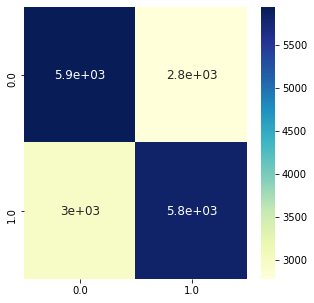

In [14]:
confMatrix = confusion_matrix(yTest, predicted)
confMatrixDF = pd.DataFrame(confMatrix, index = np.unique(yTest), columns = np.unique(yTest))

plt.figure(figsize=(5,5))
sb.heatmap(confMatrixDF, annot=True, annot_kws={"size": 12}, cmap="YlGnBu")

In [15]:
confMatrixDF

,0.0,1.0
0.0,5941,2777
1.0,2955,5827


## 2.2 Gaussian discriminant analysis

In [57]:
def train_gaussian_discriminant_analysis(matrix_x, vector_y):
    
    classes, num_occurrences = np.unique(vector_y, return_counts=True)
    
    odds =  num_occurrences / len(vector_y)
    
    means = np.ones((len(classes), matrix_x.shape[1]) , dtype=float)
    
    covariance = np.ones((len(classes), matrix_x.shape[1], matrix_x.shape[1]), dtype=float)
        
    for k in range(len(classes)):
        
        class_element = matrix_x[vector_y==k]    
        
        means[k] = np.mean(class_element, axis=0)
        
        sum_cov = np.ones((matrix_x.shape[1], matrix_x.shape[1]), dtype=float)
        
        for i in range (class_element.shape[0]):    
            sum_cov += np.outer((class_element[i] - means[k]),(class_element[i] - means[k]))
        covariance[k] = sum_cov /(num_occurrences[k] -1)         

    return means, covariance, odds

In [58]:
def make_predict_gda(x, means, covariance, odds, d):
    
    num_classes = len(odds)
    
    odds_class = np.zeros(num_classes)     
    
    for k in range(num_classes):
        
        determinante = np.linalg.det(covariance[k])
                
        part1 = np.log2(determinante)
        
        part2 = (np.transpose(x - means[k]).dot(np.linalg.inv(covariance[k]))).dot(x - means[k])
        
        prediction = np.log2(odds[k]) -1/2 * part1 -1/2 * part2 
        
        odds_class[k] = prediction
        
    return odds_class

In [59]:
def gaussian_discriminant_analysis(xTrain, yTrain, xTest):
    
    means, covariance, odds = train_gaussian_discriminant_analysis(xTrain, yTrain)
    arrau_p = []
    size = (xTrain.shape[0], len(odds))
    predictions = np.ones(size, dtype=float)
    d = xTrain.shape[1]
    
    for i in range(xTest.shape[0]):
        predictions[i] = make_predict_gda(xTest[i], means, covariance, odds, d)
        index = np.argmax(predictions[i], axis=0)
        arrau_p.append(index)
            
    return np.array(arrau_p)

In [60]:
predictions = gaussian_discriminant_analysis(xTrain, yTrain, xTest)

In [61]:
accuracy(predictions, yTest)

57.32000000000001

In [62]:
print(classification_report(yTest, predictions))

              precision    recall  f1-score   support

         0.0       0.54      0.90      0.68      8686
         1.0       0.72      0.25      0.37      8814

    accuracy                           0.57     17500
   macro avg       0.63      0.58      0.52     17500
weighted avg       0.63      0.57      0.52     17500



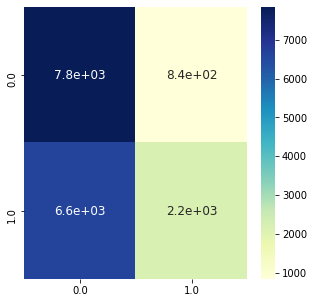

In [63]:
confMatrix = confusion_matrix(yTest, predictions)
confMatrixDF = pd.DataFrame(confMatrix, index = np.unique(yTest), columns = np.unique(yTest))

plt.figure(figsize=(5,5))
sb.heatmap(confMatrixDF, annot=True, annot_kws={"size": 12}, cmap="YlGnBu")

In [64]:
confMatrixDF

,0.0,1.0
0.0,7843,843
1.0,6626,2188


0.5755943527767375


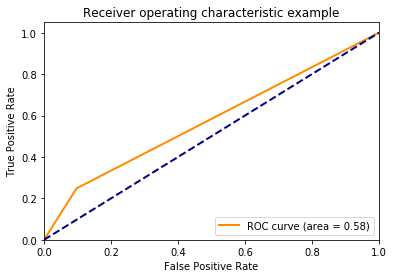

In [65]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(yTest, predictions)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(yTest, predictions))
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## 2.2.1 Naive Gaussian discriminant analysis

In [50]:
def compute_NaiveGaussians(xTrain,yTrain):
    means = list()
    variances = list()
    prob = list()
    
     
    for i in range(int(np.amax(yTrain))+1): #np.amax indicates the number of Classes (assuming each class identifies as an integer starting with 0)
        means.append(np.mean(xTrain[np.argwhere(yTrain == i)] , 0 ))
        variances.append(np.std(xTrain[np.argwhere(yTrain == i)] , 0 )) 
        prob.append(len(np.argwhere(yTrain ==i)) /len(yTrain))
 
    return prob, means, variances


def NBayes_Gaussian(xTrain, yTrain, xTest): 
    prob, means, variances = compute_NaiveGaussians(xTrain,yTrain)
    prediction = list() 
    APLog = np.zeros([len(xTest),len(prob) ])   
    for i in range(len(xTest)):
        for j in range(len(prob)): 
            APLog[i,j] = prob[j] - 1/2*np.sum(np.log(2*np.pi*variances[j]))-1/2*np.sum(np.divide(np.square(xTest[i]-means[j]),variances[j]))
         
 
    prediction = np.argmax(APLog,1)  
     
            
    return prediction

In [51]:
predictions = NBayes_Gaussian(xTrain, yTrain, xTest)

In [52]:
accuracy(predictions, yTest)

66.21142857142857

In [53]:
print(classification_report(yTest, predictions))

              precision    recall  f1-score   support

         0.0       0.63      0.77      0.69      8686
         1.0       0.71      0.56      0.62      8814

    accuracy                           0.66     17500
   macro avg       0.67      0.66      0.66     17500
weighted avg       0.67      0.66      0.66     17500



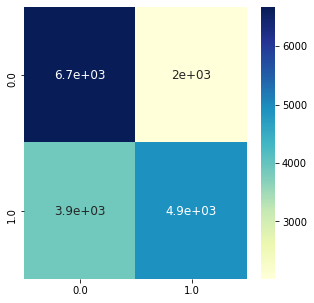

In [54]:
confMatrix = confusion_matrix(yTest, predictions)
confMatrixDF = pd.DataFrame(confMatrix, index = np.unique(yTest), columns = np.unique(yTest))

plt.figure(figsize=(5,5))
sb.heatmap(confMatrixDF, annot=True, annot_kws={"size": 12}, cmap="YlGnBu")

In [55]:
confMatrixDF

,0.0,1.0
0.0,6670,2016
1.0,3897,4917


0.662882431561661


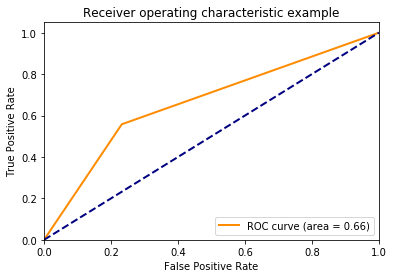

In [56]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(yTest, predictions)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(yTest, predictions))
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Logistic regression

In [66]:
def normalization(matrix, vector):
    #Mean calculation
    mVector = np.mean(vector, axis=0)
    mMatrix = np.mean(matrix, axis=0)
    
    #Standard deviation
    stdVector = np.std(vector, axis = 0)
    stdMatrix = np.std(matrix, axis = 0)
     
    #Normalization of data
    vector = (vector - mVector)/stdVector
    matrix = (matrix - mMatrix)/stdMatrix
    
    return matrix, vector

In [67]:
def sigmoide(z):
    return 1 / (1 + np.exp(-z))

In [68]:
def predict_logistic_regression_binary(matrix_x, w):
    
    predictions = []
    matrix_x = np.insert(matrix_x, 0, 1, axis =1)
    for i in range(matrix_x.shape[0]):
        predictions.append(round(sigmoide(matrix_x[i].dot(w))))
        
    return predictions

In [83]:
def predict_logistic_regression_binary_proba(matrix_x, w):
    
    predictions = []
    matrix_x = np.insert(matrix_x, 0, 1, axis =1)
    for i in range(matrix_x.shape[0]):
        predictions.append(sigmoide(matrix_x[i].dot(w)))
        
    return predictions

In [69]:
def stochastic_gradient_descent(matrix_x, vector_y, epochs, alpha):
    matrix_x = np.insert(matrix_x, 0, 1, axis =1)
    w_matrix = np.ones((matrix_x.shape[1],), dtype=float)
    y_predicted = matrix_x.dot(w_matrix)
    data =np.append(matrix_x, np.split(vector_y, matrix_x.shape[0], axis=0), axis=1)
    mse = []

    for epoch in range(epochs):
        erro = 0
        somatorio = 0
        for i in range(matrix_x.shape[0]):
            w_matrix  = w_matrix + alpha * (vector_y[i] - sigmoide(y_predicted[i])) * matrix_x[i]
            somatorio += (vector_y[i] - sigmoide(y_predicted[i])) * matrix_x[i]
        
        mse.append((-1/matrix_x.shape[0]) * somatorio)        
        data = np.random.permutation(data)
        matrix_x = data[: ,0:matrix_x.shape[1]]
        vector_y = data[:,matrix_x.shape[1]]
        
        y_predicted = matrix_x.dot(w_matrix)  
    
    return w_matrix, mse

In [70]:
matrix_x, vector_y = normalization(xTrain, yTrain)

In [71]:
matrix_x_test, vector_y_test = normalization(xTest, yTest)

In [72]:
w, mse = stochastic_gradient_descent(matrix_x, vector_y, 1000, 0.001)

In [73]:
predictions_logistic = predict_logistic_regression_binary(matrix_x_test, w)

In [84]:
predictions_logistic_proba = predict_logistic_regression_binary_proba(matrix_x_test, w)

In [92]:
accuracy(predictions_logistic, yTest)

57.19428571428572

In [75]:
print(classification_report(yTest, predictions_logistic))

              precision    recall  f1-score   support

         0.0       0.54      0.93      0.68      8686
         1.0       0.77      0.22      0.34      8814

    accuracy                           0.57     17500
   macro avg       0.65      0.57      0.51     17500
weighted avg       0.65      0.57      0.51     17500



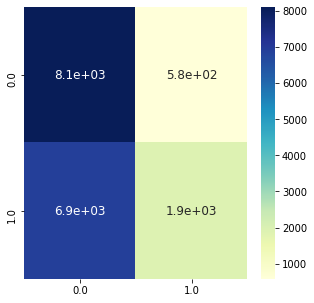

In [76]:
confMatrix = confusion_matrix(yTest, predictions_logistic)
confMatrixDF = pd.DataFrame(confMatrix, index = np.unique(yTest), columns = np.unique(yTest))

plt.figure(figsize=(5,5))
sb.heatmap(confMatrixDF, annot=True, annot_kws={"size": 12}, cmap="YlGnBu")

In [41]:
confMatrixDF

,0.0,1.0
0.0,8181,595
1.0,6820,1904


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.583


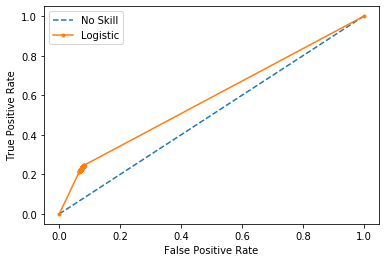

In [94]:
ns_probs = [0 for _ in range(len(yTest))]
# fit a model
# predict probabilities
lr_probs = predictions_logistic_proba
# keep probabilities for the positive outcome only
lr_probs = lr_probs
# calculate scores
ns_auc = roc_auc_score(yTest, ns_probs)
lr_auc = roc_auc_score(yTest, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(yTest, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(yTest, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()